In [2]:
import json
import re
import gensim
import nltk
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

## V1 fine tune adatkészlet elemzése

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("punkt_tab")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\szoko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\szoko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\szoko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
database = 'database_packs/training_v1/training_v1.jsonl'

# Load JSONL file
with open(database, "r", encoding="utf-8") as f:
    poems = [json.loads(line)["text"] for line in f]

# Define custom stop words
custom_stop_words = {
    "love", "heart", "night", "shadows", "like", "time", "light", 
    "dreams", "life", "dark", "day", "lost", "yet", "truth", "beneath"
}

# Combine with NLTK stop words
stop_words = set(stopwords.words("english")).union(custom_stop_words)

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\W+', ' ', text.lower())  # Remove punctuation
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words and len(word) > 2]

# Tokenize and prepare documents
processed_poems = [preprocess_text(poem) for poem in poems]


In [6]:
from gensim import corpora

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_poems)
corpus = [dictionary.doc2bow(poem) for poem in processed_poems]


In [7]:
from gensim.models import LdaModel

num_topics = 15

# Train LDA model
# Train LDA model with more topics and adjusted hyperparameters
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary, 
                     num_topics=num_topics, 
                     random_state=42, 
                     passes=10, 
                     alpha=0.01, 
                     eta=0.1,
                     per_word_topics=True)



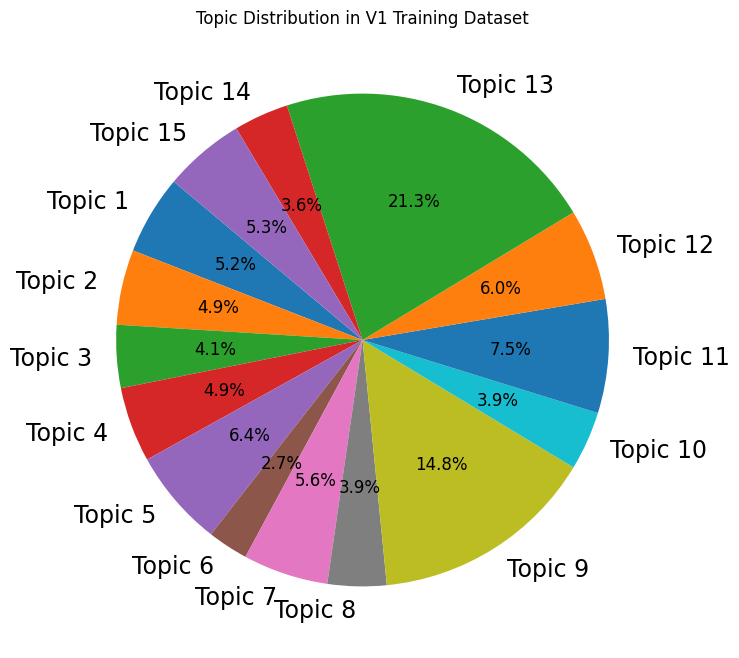

Entropy of Topic Distribution in V1 Training Dataset: 2.5167
Maximum Entropy for 15 Topics: 3.9069


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Step 1: Calculate Topic Distribution
topic_counts = [0] * lda_model.num_topics
for doc in corpus:
    topic_probs = lda_model.get_document_topics(doc)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    topic_counts[dominant_topic] += 1

# Convert counts to proportions
topic_proportions = np.array(topic_counts) / len(corpus)

# Step 2: Plot Pie Chart for Topic Distribution
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(topic_proportions, labels=[f"Topic {i+1}" for i in range(len(topic_proportions))],
                                   autopct="%1.1f%%", startangle=140, textprops={"fontsize": 18})
plt.title("Topic Distribution in V1 Training Dataset")

# Adjust the font size of the labels
for text in texts:
    text.set_fontsize(17)  # Set the desired font size for the labels

# Adjust the font size of the numbers
for autotext in autotexts:
    autotext.set_fontsize(12)  # Set the desired font size for the numbers

plt.show()

# Step 3: Calculate Entropy for Diversity
dataset_entropy = entropy(topic_proportions)
print(f"Entropy of Topic Distribution in V1 Training Dataset: {dataset_entropy:.4f}")

def calculate_max_entropy(num_topics):
    probability = 1 / num_topics  # Uniform distribution for each topic
    max_entropy = -num_topics * (probability * np.log2(probability))
    return max_entropy

# Calculate and print the maximum entropy
num_topics = lda_model.num_topics
max_entropy = calculate_max_entropy(num_topics)
print(f"Maximum Entropy for {num_topics} Topics: {max_entropy:.4f}")


## Koherenciaszámítás

In [9]:
from gensim.models import CoherenceModel

# Calculate coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_poems, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda:.4f}')

Coherence Score: 0.3808


In [10]:
# Display top words for each topic
num_words = 10  # Number of top words per topic
for topic_id in range(lda_model.num_topics):
    top_words = lda_model.show_topic(topic_id, topn=num_words)
    print(f"Top {num_words} words for Topic {topic_id + 1}: {[word for word, prob in top_words]}")


Top 10 words for Topic 1: ['one', 'king', 'may', 'sir', 'god', 'thou', 'eyes', 'never', 'long', 'arthur']
Top 10 words for Topic 2: ['sea', 'dance', 'whispers', 'realm', 'spectral', 'play', 'sun', 'twilight', 'echoes', 'verse']
Top 10 words for Topic 3: ['say', 'fiddle', 'thou', 'proputty', 'whats', 'one', 'munny', 'make', 'well', 'must']
Top 10 words for Topic 4: ['one', 'water', 'house', 'dont', 'river', 'know', 'see', 'say', 'walk', 'white']
Top 10 words for Topic 5: ['one', 'world', 'people', 'would', 'shed', 'saw', 'eyes', 'long', 'never', 'man']
Top 10 words for Topic 6: ['dream', 'weaves', 'laughter', 'bright', 'air', 'moon', 'back', 'every', 'something', 'one']
Top 10 words for Topic 7: ['thy', 'death', 'man', 'trees', 'said', 'moon', 'back', 'new', 'one', 'american']
Top 10 words for Topic 8: ['dear', 'every', 'world', 'morning', 'cup', 'soul', 'man', 'name', 'rose', 'never']
Top 10 words for Topic 9: ['whispers', 'secrets', 'echoes', 'one', 'wind', 'dance', 'air', 'eyes', 'fo

In [11]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize topics using PyLDAvis
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)